read standard instances of the  traveling salesman problem

Copyright (c) by Joao Pedro PEDROSO and Mikio KUBO, 2012

In [2]:
import math
import networkx as nx
import gurobipy as gp
import matplotlib.pyplot as plt
import gzip
import math

In [3]:
"""
solve_tsp -- solve the traveling salesman problem 
- start with assignment model
- add cuts until there are no sub-cycles

Parameters:
- V: set/list of nodes in the graph
- c[i,j]: cost for traversing edge (i,j)

Returns the optimum objective value and the list of edges used.
"""

def solve_tsp(V,c):

        
    def addcut(cut_edges):
        G = nx.Graph()
        G.add_edges_from(cut_edges)
        Components = list(nx.connected_components(G))

        if len(Components) == 1:
            return False
        
        for S in Components:
            model.addConstr(gp.quicksum(x[i,j] for i in S for j in S if j>i) <= len(S)-1)
            #print("cut: len(%s) <= %s" % (S,len(S)-1))
        
        return True
    
    def addcut2(cut_edges):
        G = nx.Graph()
        G.add_edges_from(cut_edges)
        Components = list(nx.connected_components(G))

        if len(Components) == 1:
            return False
        
        for S in Components:
            T = set(V) - set(S)
            #print("S:",S)
            #print("T:",T)
            model.addConstr(gp.quicksum(x[i,j] for i in S for j in T if j>i) >= 2)
            #print("cut: %s <--> %s >= 2" % (S,T), [(i,j) for i in S for j in T if j>i])
        return True

    # main part of the solution process:
    model = gp.Model("tsp")

    model.Params.OutputFlag = 0 # silent/verbose mode
    
    x = {}
    for i in V:
        for j in V:
            if j > i:
                x[i,j] = model.addVar(ub=1.0, name="x(%s,%s)"%(i,j))
    model.update()
    
    for i in V:
        model.addConstr(gp.quicksum(x[j,i] for j in V if j < i) + gp.quicksum(x[i,j] for j in V if j > i) == 2, "degree(%s)"%i)

    model.setObjective(gp.quicksum(c[i,j]*x[i,j] for i in V for j in V if j > i), gp.GRB.MINIMIZE)
    
    # cut stratege
    EPS = 1.e-6
    while True:
        model.optimize()
        edges = []
        for (i,j) in x:
            if x[i,j].X > EPS:
                edges.append((i,j))

        if addcut(edges) == False:
            # integer variables, components connected: solution found
            if model.IsMIP:     
                break
            # all components connected, switch to integer model
            for (i,j) in x: 
                x[i,j].VType = "B"

            model.update()

    # get objval
    objval = model.ObjVal

    # get tour
    val_edges = []
    for (i,j) in x:
        if j > i:
            if x[i,j].X > 0.5:
                val_edges.append((i,j))

    return objval, val_edges

In [4]:
def distL2(x1,y1,x2,y2):
    """Compute the L2-norm (Euclidean) distance between two points.

    The distance is rounded to the closest integer, for compatibility
    with the TSPLIB convention.

    The two points are located on coordinates (x1,y1) and (x2,y2),
    sent as parameters"""
    xdiff = x2 - x1
    ydiff = y2 - y1
    return int(math.sqrt(xdiff*xdiff + ydiff*ydiff) + .5)


def distL1(x1,y1,x2,y2):
    """Compute the L1-norm (Manhattan) distance between two points.

    The distance is rounded to the closest integer, for compatibility
    with the TSPLIB convention.

    The two points are located on coordinates (x1,y1) and (x2,y2),
    sent as parameters"""
    return int(abs(x2-x1) + abs(y2-y1)+.5)


In [5]:
def read_tsplib(filename):
    "basic function for reading a symmetric problem in the TSPLIB format"
    "data is stored in an upper triangular matrix"
    "NOTE: some distance types are not handled yet"
    
    if filename[-3:] == ".gz":
        f = gzip.open(filename)
    else:
        f = open(filename)

    line = f.readline()
    
    while line.find("DIMENSION") == -1:
        line = f.readline()

    n = int(line.split()[-1])

    while line.find("EDGE_WEIGHT_TYPE") == -1:
        line = f.readline()

    if line.find("EUC_2D") != -1:
        dist = distL2
    elif line.find("MAN_2D") != -1:
        dist = distL1
    else:
        print("cannot deal with '%s' distances" % line)
        raise Exception

    while line.find("NODE_COORD_SECTION") == -1:
        line = f.readline()

    # coord
    x, y = {},{}
    points = []
    while 1:
        line = f.readline()
        if line.find("EOF") != -1 or not line: break
        (i,xi,yi) = line.split()
        x[i] = float(xi)
        y[i] = float(yi)
        points.append((x[i],y[i]))

    V = x.keys()
    c = {}   # distance
    for i in V:
        for j in V:
            c[i,j] = dist(x[i],y[i],x[j],y[j])

    print(c)

    return V, c, x, y, points

In [6]:
file_name = "instances/tsplib/a280.tsp"

V, c, x, y, points = read_tsplib(file_name)
print(len(V), "vertices,", len(c), "arcs")

X = [x[0] for x in points]
Y = [y[1] for y in points]

{('1', '1'): 0, ('1', '2'): 20, ('1', '3'): 24, ('1', '4'): 33, ('1', '5'): 33, ('1', '6'): 43, ('1', '7'): 56, ('1', '8'): 63, ('1', '9'): 61, ('1', '10'): 71, ('1', '11'): 79, ('1', '12'): 86, ('1', '13'): 94, ('1', '14'): 102, ('1', '15'): 93, ('1', '16'): 100, ('1', '17'): 116, ('1', '18'): 124, ('1', '19'): 132, ('1', '20'): 140, ('1', '21'): 148, ('1', '22'): 141, ('1', '23'): 126, ('1', '24'): 118, ('1', '25'): 134, ('1', '26'): 149, ('1', '27'): 157, ('1', '28'): 165, ('1', '29'): 172, ('1', '30'): 184, ('1', '31'): 184, ('1', '32'): 185, ('1', '33'): 199, ('1', '34'): 208, ('1', '35'): 224, ('1', '36'): 225, ('1', '37'): 233, ('1', '38'): 232, ('1', '39'): 232, ('1', '40'): 232, ('1', '41'): 232, ('1', '42'): 233, ('1', '43'): 234, ('1', '44'): 250, ('1', '45'): 249, ('1', '46'): 248, ('1', '47'): 248, ('1', '48'): 248, ('1', '49'): 248, ('1', '50'): 249, ('1', '51'): 257, ('1', '52'): 256, ('1', '53'): 256, ('1', '54'): 256, ('1', '55'): 256, ('1', '56'): 257, ('1', '57'): 25

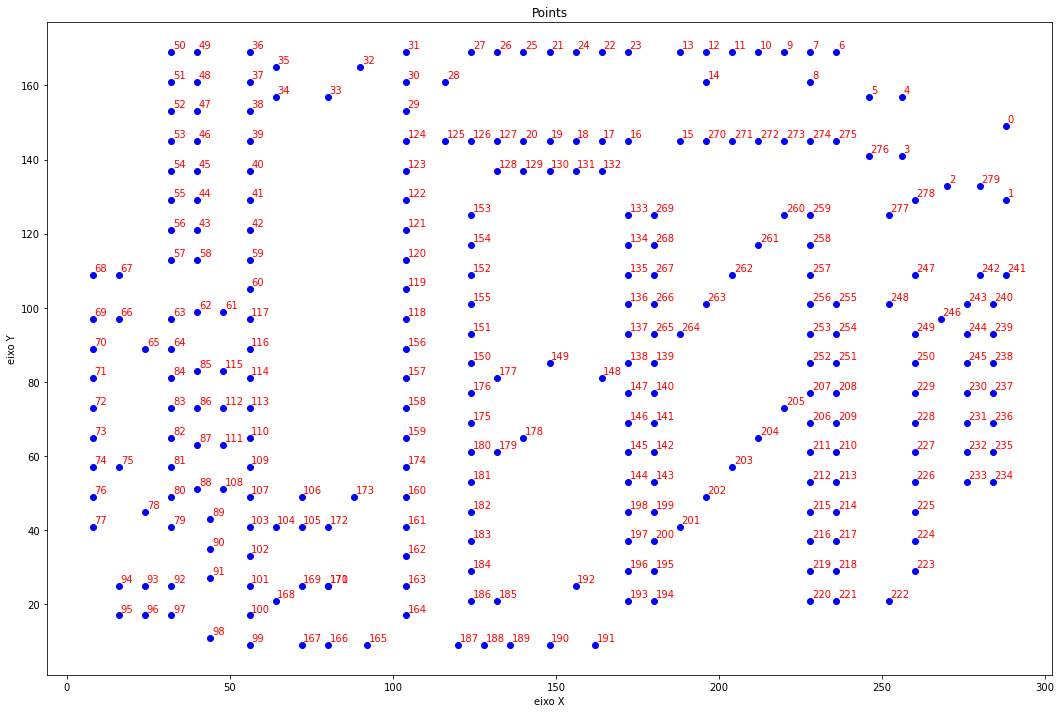

In [7]:
plt.figure(figsize=(18,12))
plt.scatter(X,Y,color='blue')

for t in range(len(X)):
    plt.annotate(str(t), xy=(X[t],Y[t]), xytext = (X[t]+0.5, Y[t]+1), color='red')

plt.xlabel("eixo X")
plt.ylabel("eixo Y")
plt.title("Points")
plt.show()

In [8]:
opt_tour, objval = solve_tsp(V, c)

print("Optimal tour:", opt_tour)
print("Optimal cost:", objval)


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-15
Optimal tour: 2579.0
Optimal cost: [('1', '2'), ('1', '280'), ('2', '242'), ('4', '5'), ('5', '6'), ('6', '7'), ('7', '8'), ('8', '9'), ('10', '9'), ('10', '11'), ('11', '12'), ('12', '15'), ('13', '14'), ('13', '15'), ('14', '24'), ('16', '17'), ('16', '271'), ('17', '18'), ('18', '19'), ('20', '21'), ('22', '25'), ('22', '26'), ('23', '24'), ('23', '25'), ('26', '27'), ('27', '28'), ('28', '29'), ('29', '31'), ('31', '32'), ('32', '33'), ('33', '34'), ('34', '35'), ('35', '36'), ('36', '37'), ('37', '38'), ('38', '39'), ('39', '40'), ('40', '41'), ('41', '42'), ('42', '43'), ('43', '60'), ('44', '45'), ('44', '59'), ('45', '46'), ('46', '47'), ('47', '48'), ('48', '49'), ('49', '50'), ('50', '51'), ('51', '52'), ('52', '53'), ('53', '54'), ('54', '55'), ('55', '56'), ('56', '57'), ('57', '58'), ('58', '68'), ('59', '62'), ('60', '61'), ('62', '63'), ('63', '64'), ('64', '65'), ('65', '66'), ('6